# 🪙 Modele de predicție a prețului Bitcoin
### ANALIZĂ DE DATE ȘI ALGORITMI DE ÎNVĂȚARE AUTOMATĂ PENTRU PREDICȚIA PREȚULUI BITCOIN

**Autor:** *Cristiana Kovacs*  

---

## 🎯 Obiectivul proiectului

Scopul acestui proiect este dezvoltarea și evaluarea unor modele de învățare automată pentru **prognoza prețului de închidere al Bitcoin**, pe baza unui set extins de date:
- financiare (prețuri, indici bursieri),
- macroeconomice (inflație, rate ale dobânzilor),
- on-chain (indicatori blockchain),
- și parțial, date de sentiment.

Obiectivul este **obținerea unei erori de predicție cât mai reduse (MAE)** și identificarea variabilelor cu influență majoră asupra prețului Bitcoin.

---

## 💡 Aplicații practice posibile

- Suport pentru **investitori și traderi**, ca punct suplimentar de referință în luarea deciziilor.  
- Analiză de **scenarii „ce s-ar întâmpla dacă?”** (impactul factorilor externi asupra prețului).  
- Monitorizarea **factorilor cu cea mai mare influență** (variabile importante identificate de model).
- **Monitorizarea automată** a prețului BTC în timp real, cu alerte atunci când deviația depășește un prag (ex. ±2%)..
- **Predicții zilnice** sau pe orizont scurt (1–3 zile) pentru sisteme de risk management sau pentru ajustarea pozițiilor de tranzacționare.
- **Suport pentru analiza** scenariilor („ce s-ar întâmpla dacă?”) prin simularea diferitelor evoluții de preț.
- Integrare într-un **dashboard de forecast** pentru vizualizarea simultană a predicției și a deviației procentuale în timp real.



In [ ]:
# Instalari necesare:

!pip install catboost --quiet
!pip install tensorflow --quiet
!pip install lightgbm --quiet
!pip install statsmodels --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install pandas --quiet
!pip install numpy --quiet

print('Instalarile au fost facute cu succes.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.0 MB/s eta 0:00:00
Instalarile au fost facute cu succes.


In [ ]:
# Importuri folosite

# Manipulare date:

import pandas as pd
import numpy as np
import os
from functools import reduce

# Vizualizare:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import seaborn as sns
import scipy.stats as stats
from scipy.signal import find_peaks

# Machine Learning / Statistici:

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

# Modele Avansate / Boosting:

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

# Time series:

from statsmodels.tsa.arima.model import ARIMA

# Deep Learning:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Colab / Notebook:

from google.colab import drive
from IPython.display import display

# Unilaterale:

import warnings
from itertools import product

print('Bibliotecile au fost importate cu succes.')

Bibliotecile au fost importate cu succes.


# 🧱 Etapa I: Construirea și curățarea bazei de date

## 🔹 Surse de date utilizate

| Tip date | Sursă | Variabile principale |
|-----------|--------|-----------------------|
| Prețuri Bitcoin | Yahoo Finance | Open, High, Low, Close, Volume |
| Active financiare | Yahoo Finance | Gold, Oil, SP500, DXY, VIX |
| Randamente TIPS | FRED | TIPS 5Y, 10Y |
| Date macroeconomice | FRED | Fed Funds Rate, CPI, Unemployment |
| Date on-chain | Blockchain.com API | n-transactions, hash-rate, difficulty |
| Sentiment (limitat) | CoinDesk, Reddit | scoruri pozitive/negative |

---

## 🧹 Preprocesare

1. Conversie coloanei `Date` la format datetime.  
2. Conversie numerică a coloanelor relevante (float, 2 zecimale).  
3. Completarea valorilor lipsă – metodă *forward fill*.
4. Detectarea outlierilor – metodă *IQR (Interquartile Range)*.  
    - `Q1 - 1.5*IQR și Q3 + 1.5*IQR`
    - Marcarea rândurilor cu valori extreme, fără a le elimina imediat

5. Verificarea consistenței prețurilor Bitcoin:  
   - `Low ≤ Open/Close ≤ High`.  
6. **Unificarea** dataseturilor pe coloana `Date` (outer join).  
7. Sortarea datelor cronologic.
8. Rezultat: dataset integrat cu toate variabilele relevante (financiare, macro, sentiment, on-chain).

## 🧹 Curățarea dateset final

1. Eliminarea rândurilor incomplete la începutul seriei (care conțin NaN în majoritatea coloanelor).
2. Forward fill pentru completarea valorilor lipsă restante.
3. Asigurarea consistenței finale a datelor și a coloanelor critice

## 💾 Validareadata set

1. Vizualizarea primelor 20 de rânduri pentru verificarea consistenței.
2. Confirmarea respectării relațiilor logice între prețurile Bitcoin **(Low ≤ Open/Close ≤ High)**.
3. Analiza procentului de outlieri pentru a evalua calitatea datasetului **(percentila 99.9%).
---

## 🧾 Rezultatul final

📊 Baza de date finală conține **3967 rânduri** și **19 coloane.**

🚨 Număr de linii care conțin cel puțin un **outlier: 925**

📈 **Procentul** rândurilor cu **outlieri: 23.32% din total.**

- valori care ies semnificativ din intervalul obișnuit (adică outlierii) nu înseamnă neapărat erori, ci reflectă evenimente reale și relevante pe piață.
- eliminarea lor ar fi echivalentă cu ștergerea unor evenimente importante din - setul de date, ceea ce ar distorsiona analiza statistică.
- practic, 1 din 4 sau 1 din 5 rânduri conține o valoare extremă, dar aceste valori pot fi chiar cele mai interesante pentru analize: ele indică crize, vârfuri sau scăderi abrupte, care sunt esențiale pentru înțelegerea comportamentului pieței.

**Nu elimin outlierii: pentru date financiare volatile precum Bitcoin, ei sunt parte din realitate!**



In [ ]:
# @title
# Baza de date
# Incarcare fisier
cale_fisier = "/content/drive/My Drive/Bitcoin test/merge data bitcoin.csv"

df = pd.read_csv(cale_fisier)
print("Primele 30 de rânduri din fișier:")
display(df.head(30))

Primele 30 de rânduri din fișier:


,Date,Open,High,Low,Close,Volume,GOLD_Close,OIL_Close,SP500_Close,DXY_Close,VIX_Close,TIPS_5Y_Yield,TIPS_10Y_Yield,Fed Funds Rate,CPI,Unemployment Rate,n-transactions,hash-rate,difficulty
0,2014-09-17,465.86,468.17,452.42,457.33,21056800.0,1234.4,94.42,2001.57,84.70,12.65,0.19,0.56,0.09,237.48,5.9,80305,280257.53,2.982973e+10
1,2014-09-18,456.86,456.86,413.10,424.44,34483200.0,1225.7,93.07,2011.36,84.32,12.03,0.29,0.61,0.09,237.48,5.9,77364,274326.15,2.982973e+10
2,2014-09-19,424.10,427.83,384.53,394.80,37919700.0,1215.3,92.41,2010.40,84.80,12.11,0.27,0.56,0.09,237.48,5.9,69437,240220.74,2.982973e+10
3,2014-09-20,394.67,423.30,389.88,408.90,36863600.0,1215.3,92.41,2010.40,84.80,12.11,0.27,0.56,0.09,237.48,5.9,63482,256532.03,2.982973e+10
4,2014-09-21,408.08,412.43,393.18,398.82,26580100.0,1215.3,92.41,2010.40,84.80,12.11,0.27,0.56,0.09,237.48,5.9,59800,259497.71,2.982973e+10
5,2014-09-22,399.10,406.92,397.13,402.15,24127600.0,1216.8,91.52,1994.29,84.67,13.69,0.20,0.58,0.09,237.48,5.9,73289,232806.52,2.982973e+10
6,2014-09-23,402.09,441.56,396.20,435.79,45099500.0,1221.0,91.56,1982.77,84.66,14.93,0.15,0.52,0.09,237.48,5.9,77283,223909.46,2.982973e+10
7,2014-09-24,435.75,436.11,421.13,423.20,30627700.0,1218.6,92.80,1998.30,85.05,13.27,0.16,0.54,0.09,237.48,5.9,74974,241703.58,2.982973e+10
8,2014-09-25,423.16,423.52,409.47,411.57,26814400.0,1221.2,92.53,1965.99,85.20,15.64,0.13,0.50,0.09,237.48,5.9,78523,241703.58,2.982973e+10
9,2014-09-26,411.43,414.94,400.01,404.42,21460800.0,1214.1,93.54,1982.85,85.64,14.85,0.21,0.57,0.09,237.48,5.9,72555,260177.35,3.466143e+10


# 📊 Etapa II: Analiză exploratorie a datelor (EDA)

## 🔍 Obiective:
- Înțelegerea distribuției datelor și a relațiilor dintre variabile.  
- Identificarea tendințelor, sezonalității și pattern-urilor majore.

---

## 📈 1. Histogramă pentru fiecare variabilă:

- Distribuția prețurilor Bitcoin este **puternic asimetrică spre dreapta (positively skewed)** – multe valori mici, puține valori extreme.  
- Majoritatea valorilor sunt concentrate sub 20,000 USD, dar există valori extreme foarte mari (până la ~120,000 USD),**coadă lungă spre dreapta.**
- Majoritatea tranzacțiilor istorice au avut prețuri relativ mici, dar au existat câteva perioade cu creșteri foarte mari ale prețului.
- Această distribuție reflectă **volatilitatea ridicată a Bitcoin.**
---
- Puterea dolarului față de un coș de valute majore.
- **Mediana (~97.34 puncte)** → istoric, un nivel mediu, dar cu variații semnificative între 85 și 115.
- **Formă aproape normală, dar cu cozi:** sugerează episoade de întărire/ slăbire puternică a USD în crize sau perioade de politică monetară agresivă.
- dolar puternic (DXY↑) → capitalul global se refugiază în USD, presiune negativă pe Bitcoin și active riscante
- dolar slab (DXY↓) → stimulează lichiditatea și fluxurile spre Bitcoin și piețe emergente.


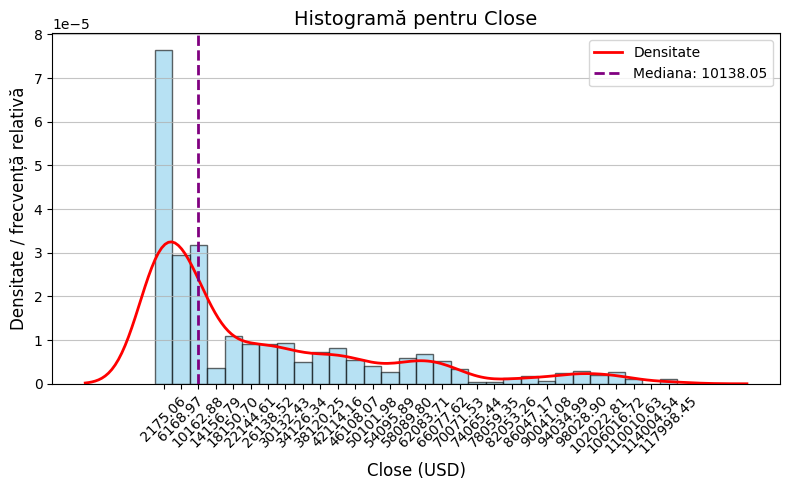

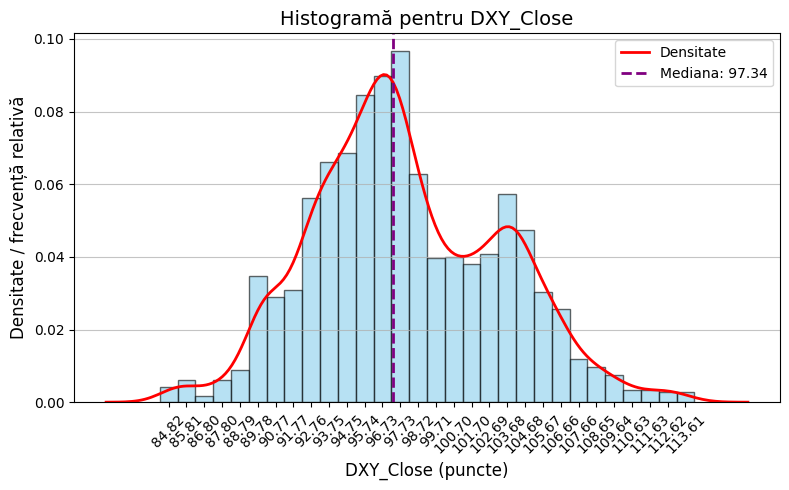

In [ ]:
# @title
# Histograme
file_path = "/content/drive/MyDrive/Bitcoin test/merge data bitcoin.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])

# Dicționar cu unități pentru fiecare variabilă
units = {
    'Open': 'USD',
    'High': 'USD',
    'Low': 'USD',
    'Close': 'USD',
    'Volume': 'număr acțiuni',
    'GOLD_Close': 'USD/uncie',
    'OIL_Close': 'USD/baril',
    'SP500_Close': 'puncte',
    'DXY_Close': 'puncte',
    'VIX_Close': 'puncte',
    'TIPS_5Y_Yield': '%',
    'TIPS_10Y_Yield': '%',
    'Fed Funds Rate': '%',
    'CPI': 'puncte',
    'Unemployment Rate': '%',
    'n-transactions': 'tranzacții',
    'hash-rate': 'TH/s',
    'difficulty': 'unități protocol'
}

# Selectăm doar coloanele dorite
coloane_selectate = ['Close', 'DXY_Close']
df_select = df[coloane_selectate]

# Variabile pentru care valorile X vor fi scurtate
short_labels = ['Volume', 'n-transactions', 'hash-rate', 'difficulty']

# Bucla pentru fiecare coloană selectată
for col in df_select.columns:
    plt.figure(figsize=(8,5))

    counts, bins, patches = plt.hist(
        df_select[col],
        bins=30,
        edgecolor='black',
        color='skyblue',
        alpha=0.6,
        density=True
    )

    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Curba KDE
    sns.kdeplot(df_select[col], color='red', linewidth=2, label="Densitate")

    # Mediana
    median_val = df_select[col].median()
    plt.axvline(median_val, color='purple', linestyle='--', linewidth=2, label=f"Mediana: {median_val:.2f}")

    # Etichete axa X
    if col in short_labels:
        def format_large_number(x):
            if x >= 1e12:
                return f'{x/1e12:.1f}T'
            elif x >= 1e9:
                return f'{x/1e9:.1f}B'
            elif x >= 1e6:
                return f'{x/1e6:.1f}M'
            elif x >= 1e3:
                return f'{x/1e3:.1f}K'
            else:
                return f'{x:.0f}'
        plt.xticks(bin_centers, [format_large_number(x) for x in bin_centers], rotation=45, fontsize=10)
    else:
        plt.xticks(bin_centers, [f"{x:.2f}" for x in bin_centers], rotation=45, fontsize=10)

    # Titlu și etichete
    plt.title(f"Histogramă pentru {col}", fontsize=14)
    plt.xlabel(f"{col} ({units.get(col, 'unități')})", fontsize=12)
    plt.ylabel("Densitate / frecvență relativă", fontsize=12)
    plt.grid(axis='y', alpha=0.75)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 📅 2. Heatmap pentru corelații:

**Matrice de corelații Pearson** pentru toate variabilele numerice selectate:
- Valorile merg de la **-1 (corelație negativă puternică) la +1 (corelație pozitivă puternică).**
- **Zonele roșii** → corelație pozitivă mare (când o variabilă crește, crește și cealaltă).
- **Zonele albastre** → corelație negativă (una urcă, cealaltă coboară).
- **Zonele aproape albe** → corelație foarte slabă / aproape inexistentă.
- **Open, High, Low, Close** sunt corelate aproape perfect între ele (0.99–1.00). Asta e normal: toate sunt prețuri derivate din aceeași zi.
- **SP500_Close (0.93)** → evoluția criptomonedei (Bitcoin) e foarte legată de bursa americană.


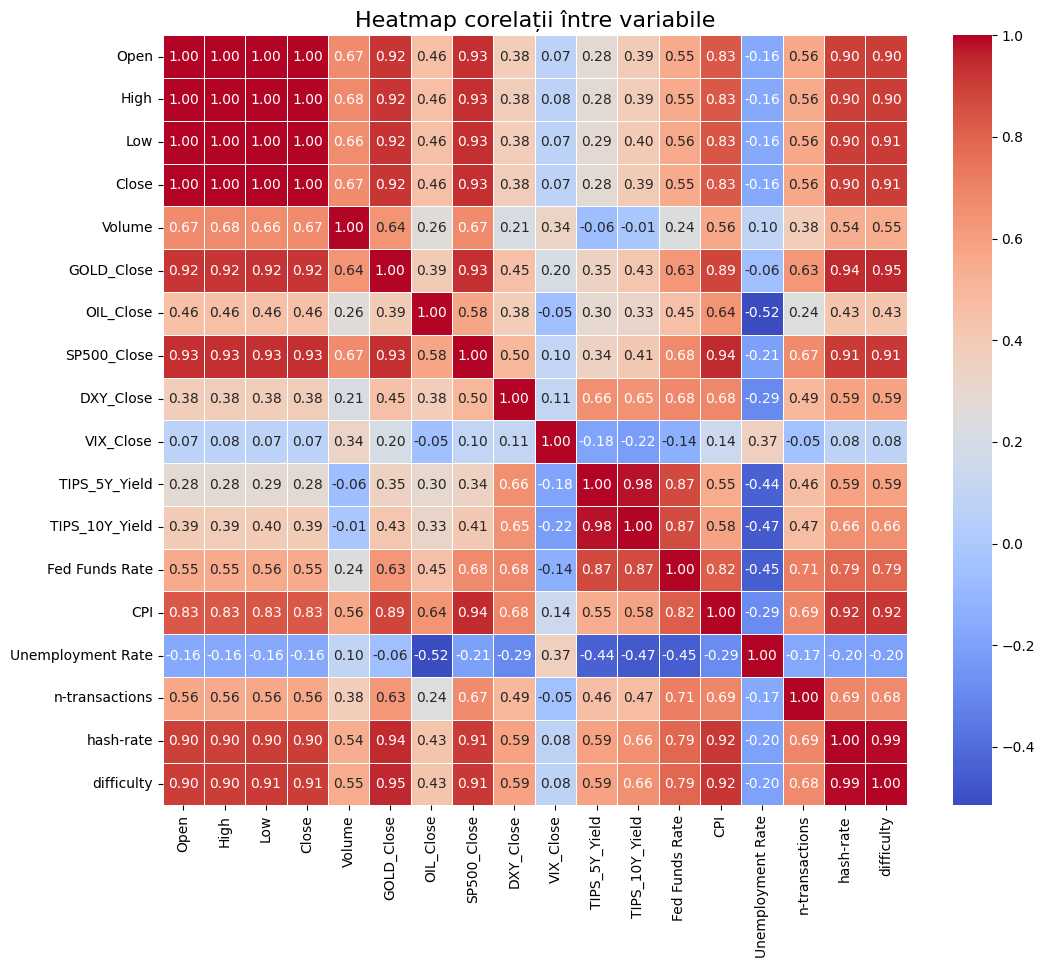

In [ ]:
# @title
# Heatmap
# Heatmap pentru corelații
corr = df_numeric.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap corelații între variabile", fontsize=16)
plt.show()


**🔝 Top 5 corelații pozitive:**
- **hash-rate ↔ difficulty = 0.99** → aproape perfect corelate (logic, dificultatea urmează puterea de calcul).
- **TIPS_5Y_Yield ↔ TIPS_10Y_Yield = 0.98** → randamentele obligațiunilor pe 5 și 10 ani merg mână în mână.
- **Open/High/Low/Close ↔ între ele = 0.99–1.00** → prețurile zilnice sunt practic identice ca tendință.
- **Close ↔ SP500_Close = 0.93** → crypto urmărește foarte strâns bursa americană.
- **Close ↔ GOLD_Close = 0.93** → crypto și aur cresc aproape simultan.

**🔻 Top 5 corelații negative:**
- **Unemployment Rate ↔ GOLD_Close = -0.52** → șomajul ridicat coincide cu scăderi la aur.
- **Unemployment Rate ↔ TIPS_10Y_Yield = -0.47** → șomaj mare = randamente reale scăzute.
- **Unemployment Rate ↔ TIPS_5Y_Yield = -0.45** → același efect, dar pe termen mai scurt.
- **Unemployment Rate ↔ Fed Funds Rate = -0.45** → șomaj ridicat forțează dobânzi mai mici.
- **DXY_Close ↔ Close = -0.28** → un dolar mai puternic înseamnă prețuri crypto mai mici.

**📌 Concluzie generală pentru acest set de date:**
- Prețurile crypto sunt extrem de aliniate cu SP500, GOLD și inflația (CPI).
- Dificultatea și hash-rate-ul blockchain-ului sunt indicatori aproape perfect corelați cu prețurile.
- Dolarul puternic (DXY) și șomajul ridicat trag prețurile în jos.
- VIX (volatilitatea) nu pare să conteze aici.
- Aurul, surprinzător, merge mână în mână cu acțiunile și crypto în acest eșantion.


## ⏳ 3. Evoluția în timp:
 **🪙 Bitcoin Close (linia albastră)**:
- a pornit sub pragul de 1.000 USD în 2015, înregistrând o creștere exponențială în 2017, până la aprox. 20.000 USD, urmată de o corecție abruptă în 2018.
- 2020–2021 a atins din nou maxime istorice (peste 60.000 USD), susținut de creșterea interesului instituțional și politicile monetare expansive.
- 2024–2025, Bitcoin depășește pragul psihologic de 100.000 USD, consolidându-se ca activ de tip „store of value”, dar menținând o volatilitate ridicată.

**🟡 Gold Close (linia galbenă):**
- Aurul a rămas un activ stabil, cu o creștere moderată de la circa 1.000 USD la peste 2.500 USD în 2025.
- În perioade de incertitudine (2020, 2022), aurul a înregistrat creșteri vizibile, confirmând rolul său tradițional de refugiu investițional („safe haven”).

**🛢️ Oil Close (linia portocalie):**
- Petrolul a fost caracterizat de volatilitate accentuată, în special în 2020, când prețurile s-au prăbușit pe fondul crizei sanitare și scăderii cererii globale.
- După 2021, prețul a revenit treptat, stabilizându-se între 60–100 USD/baril, dar performanța pe termen lung rămâne sub cea a celorlalte active.

**💹 Indicele S&P500 (SP500_Close – linie verde):**
- Indicele bursier american a înregistrat o creștere constantă de la aproximativ 2.000 puncte în 2015 la peste 6.000 în 2025.
- Corecțiile temporare (2020, 2022) au fost urmate de reveniri rapide, reflectând reziliența economiei SUA și expansiunea companiilor tehnologice.
- În ansamblu, analiza confirmă că, pe parcursul ultimului deceniu, Bitcoin s-a afirmat ca activ cu potențial investițional ridicat, dar cu un profil de risc semnificativ superior activelor tradiționale.
- Aurul și indicele S&P500 continuă să ofere stabilitate și predictibilitate pe termen lung, în timp ce petrolul rămâne sensibil la dinamica economică globală și la contextul energetic internațional.





Mounted at /content/drive


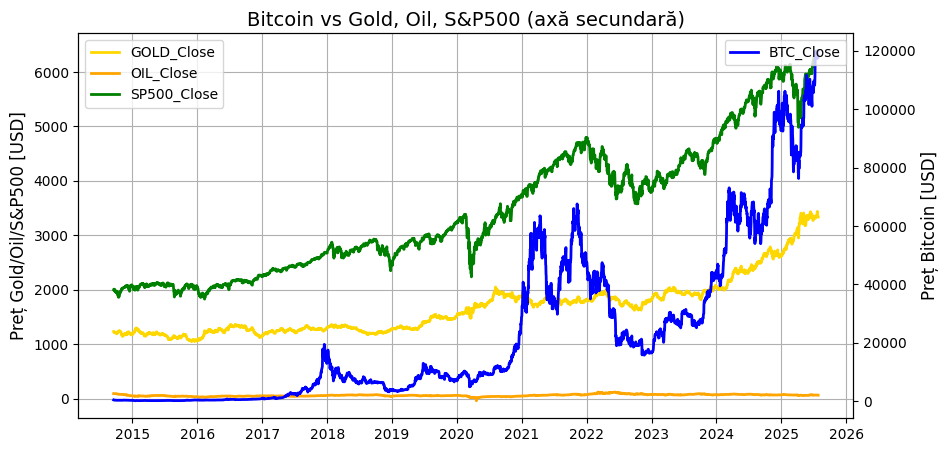

In [ ]:
# @title
# Evolutia in timp
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Bitcoin test/merge data bitcoin.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Selectăm coloanele relevante pentru vizualizare
cols_to_plot = ['Close', 'GOLD_Close', 'OIL_Close', 'SP500_Close']
df_plot = df[['Date'] + cols_to_plot].copy()

# Normalizare: fiecare serie începe de la 100
df_norm = df_plot.set_index('Date')
df_norm = df_norm / df_norm.iloc[0] * 100



# Grafic Bitcoin vs celelalte variabile cu axă secundară
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(df_plot['Date'], df_plot['GOLD_Close'], label='GOLD_Close', color='gold', linewidth=2)
ax1.plot(df_plot['Date'], df_plot['OIL_Close'], label='OIL_Close', color='orange', linewidth=2)
ax1.plot(df_plot['Date'], df_plot['SP500_Close'], label='SP500_Close', color='green', linewidth=2)
ax1.set_ylabel("Preț Gold/Oil/S&P500 [USD]", fontsize=12)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(df_plot['Date'], df_plot['Close'], label='BTC_Close', color='blue', linewidth=2)
ax2.set_ylabel("Preț Bitcoin [USD]", fontsize=12)
ax2.legend(loc='upper right')

plt.title("Bitcoin vs Gold, Oil, S&P500 (axă secundară)", fontsize=14)

# Formatare axa X pentru a afișa anii consecutivi
ax1.xaxis.set_major_locator(mdates.YearLocator())  # afișează fiecare an
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

ax1.grid(True)

plt.show()


# Creăm figura
fig = go.Figure()

# Gold
fig.add_trace(go.Scatter(
    x=df_plot['Date'],
    y=df_plot['GOLD_Close'],
    name='GOLD_Close',
    line=dict(color='gold', width=2),
    yaxis='y1'
))

# Oil
fig.add_trace(go.Scatter(
    x=df_plot['Date'],
    y=df_plot['OIL_Close'],
    name='OIL_Close',
    line=dict(color='orange', width=2),
    yaxis='y1'
))

# S&P500
fig.add_trace(go.Scatter(
    x=df_plot['Date'],
    y=df_plot['SP500_Close'],
    name='SP500_Close',
    line=dict(color='green', width=2),
    yaxis='y1'
))

# Bitcoin
fig.add_trace(go.Scatter(
    x=df_plot['Date'],
    y=df_plot['Close'],
    name='BTC_Close',
    line=dict(color='blue', width=2),
    yaxis='y2'
))

# Layout cu axă secundară
fig.update_layout(
    title='Bitcoin vs Gold, Oil, S&P500 (interactiv)',
    xaxis=dict(title='Data'),
    yaxis=dict(title='Preț Gold/Oil/S&P500 [USD]', side='left'),
    yaxis2=dict(title='Preț Bitcoin [USD]', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99),
    hovermode='x unified',
    width=1200,
    height=600
)

fig.show()

## 🔄 4. Sezonalitate sau trend:

**Număr zile în trend ascendent și descendent:**
- *Uptrend:* **2559**(zile)
- *Downtrend:* **1708**(zile)

**Sezonalitate lunară identificată:**
- *Luna cu preț mediu maxim:* **Mai** - 27470.70 USD
- *Luna cu preț mediu minim:* **Septembrie** - 17635.85 USD


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


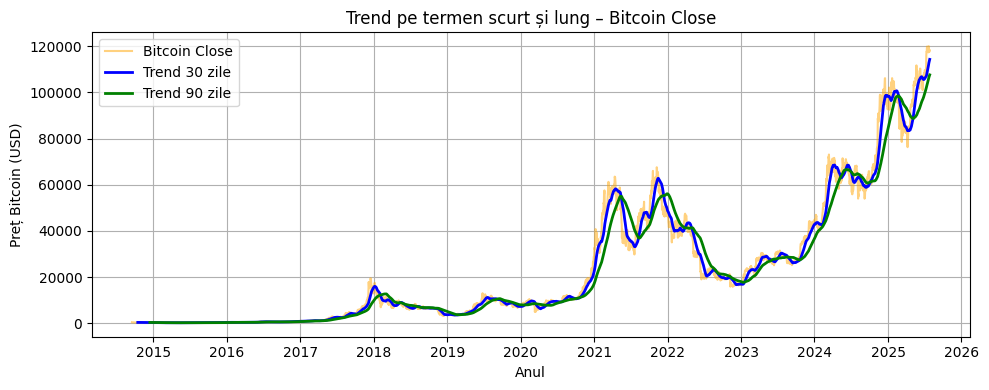

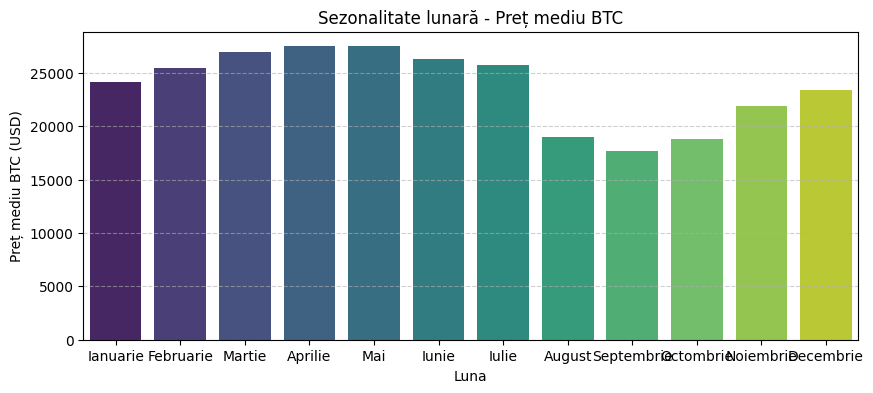

In [ ]:
# @title
# Sezonalitate sau trend
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Bitcoin test/merge data bitcoin.csv"
df = pd.read_csv(file_path, parse_dates=['Date'])
df = df.sort_values('Date')

# Trend pe termen lung – medii mobile
df['Close_30d'] = df['Close'].rolling(window=30).mean()  # trend lunar
df['Close_90d'] = df['Close'].rolling(window=90).mean()  # trend trimestrial

# Grafic trend cu ani pe axa X
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Close'], label='Bitcoin Close', color='orange', alpha=0.5)
plt.plot(df['Date'], df['Close_30d'], label='Trend 30 zile', color='blue', linewidth=2)
plt.plot(df['Date'], df['Close_90d'], label='Trend 90 zile', color='green', linewidth=2)
plt.title("Trend pe termen scurt și lung – Bitcoin Close")
plt.xlabel("Anul")
plt.ylabel("Preț Bitcoin (USD)")
plt.legend()
plt.grid(True)

# Formatare axa X pentru a afișa doar anii
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # un tick per an
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

#  Grafic sezonalitate lunară
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.dayofweek + 1  # 1=Luni ... 7=Duminică

monthly_avg = df.groupby('Month')['Close'].mean()
weekday_avg = df.groupby('Weekday')['Close'].mean()

# Dicționare pentru afișare intuitivă
month_labels = {1:'Ianuarie', 2:'Februarie', 3:'Martie', 4:'Aprilie',
                5:'Mai', 6:'Iunie', 7:'Iulie', 8:'August', 9:'Septembrie',
                10:'Octombrie', 11:'Noiembrie', 12:'Decembrie'}
weekday_labels = {1:'Luni', 2:'Marți', 3:'Miercuri', 4:'Joi', 5:'Vineri', 6:'Sâmbătă', 7:'Duminică'}

monthly_df = pd.DataFrame({
    "Luna": [month_labels[m] for m in monthly_avg.index],
    "Pret_mediu": monthly_avg.values
})

plt.figure(figsize=(10,4))
sns.barplot(data=monthly_df, x="Luna", y="Pret_mediu", hue="Luna", palette='viridis', dodge=False, legend=False)
plt.title("Sezonalitate lunară - Preț mediu BTC")
plt.xlabel("Luna")
plt.ylabel("Preț mediu BTC (USD)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


## 🕸️ 5. Pattern-uri posibile în prețul Bitcoin:

🔎 **Inversări de trend în prețul Bitcoin:**
- Trend ascendent (bullish): maxime și minime tot mai mari.
- Trend descendent (bearish): maxime și minime tot mai mici.
- Inversare de trend: momentul în care piața schimbă direcția (bullish → bearish sau invers).
- Pattern-uri tehnice semnificative: Double Top, Head & Shoulders, Zone de consolidare.
- Psihologia pieței: profit-taking după creșteri mari, panic-selling după scăderi, consolidări înainte de breakout.
- Cauze externe posibile: știri economice, reglementări guvernamentale, adopție instituțională, evenimente macroeconomice (ex: inflație, crize financiare), și sentimentul general al pieței cripto.


🕒 **Tabel cronologic cu evenimente externe majore și impact asupra BTC**

| Perioadă       | Eveniment extern major                                    | Impact asupra BTC / Trend       |
|----------------|-----------------------------------------------------------|--------------------------------|
| 2017           | Hype cripto și speculații masive                          | Creștere rapidă până la ~20.000 USD (bullish) |
| Dec 2017       | Profit-taking și reglementări mai stricte în Coreea și China | Scădere rapidă sub 4.000 USD (bearish) |
| 2020           | Adoptarea instituțională (MicroStrategy, Tesla)          | Creștere accelerată BTC (bullish) |
| 2021           | China interzice miningul și tranzacțiile crypto           | Corecție severă ~30% (bearish) |
| 2021–2022      | Creșterea ratelor dobânzii și panică pe piețele de risc  | Scădere până la ~20.000 USD (bearish) |
| 2024           | Inovații tehnologice și adopție largă                    | Consolidare 60.000–70.000 USD (neutral/bullish) |
| 2025           | Creștere infrastructură custodie și exchange-uri         | Rupere rezistență și urcare până la ~120.000 USD (bullish) |

🧩 **2017–2018:**
- BTC ajunge la ~20.000 USD → se formează un Double Top (roz) și un Head & Shoulders (verde/roșu).
- Confirmarea pattern-ului → scădere rapidă sub 4.000 USD → inversare bullish → bearish.
- **Motive posibile:** hype-ul inițial și speculațiile masive, urmate de reglementări mai stricte și panic-selling.

🧩 **2021–2022:**
- BTC atinge ~64.000 USD și apoi ~69.000 USD → Head & Shoulders clar.
- După spargerea suportului → scădere până la ~20.000 USD → exemplu clasic de inversare de trend bearish.
- **Motive posibile:** adoptarea instituțională, modificări de reglementare (China interzice miningul), creșterea ratelor dobânzii și retragerea investitorilor din activele riscante.

🧩 **2024–2025:**
- Zone de consolidare între 60.000–70.000 USD (triunghiuri gri) → prețul rupe rezistența.
- Creștere până la ~120.000 USD → inversare bullish confirmată.
- **Motive posibile:** adoptarea largă a BTC, inovații tehnologice, creștere în infrastructura de custodie și exchange-uri, și sentiment pozitiv în rândul investitorilor.

👀 **Observații practice:**
- Pattern-urile tehnice din grafic sunt foarte vizibile și pot fi folosite pentru planificarea intrărilor și ieșirilor.
- Zona de consolidare poate fi folosită ca punct de referință pentru identificarea breakout-ului.
- Confirmarea prin spargerea nivelurilor de suport/rezistență reduce riscul de semnale false.
- Analiza combinată a pattern-urilor + nivelurilor cheie + cauze externe oferă cea mai clară perspectivă asupra posibilei inversări de trend.

✅ **Concluzie finală**
- Graficul BTC arată că inversările de trend nu apar întâmplător; ele sunt semnalate clar de pattern-uri clasice și zone de consolidare.
- Investitorii pot combina teoria (Double Top, Head & Shoulders, suport/reziștență) cu observația concretă din grafic și analiza cauzelor externe pentru decizii mai informate.




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Rezumat pattern-uri tehnice detectate ===

Double Tops: 25 (confirmate: 0)
Head & Shoulders: 79
Triunghiuri de consolidare: 144

  Triunghi #1: 2015-05-09 - 2015-05-29
  Triunghi #2: 2015-05-10 - 2015-05-30
  Triunghi #3: 2015-05-11 - 2015-05-31
  Triunghi #4: 2015-05-12 - 2015-06-01
  Triunghi #5: 2016-03-06 - 2016-03-26


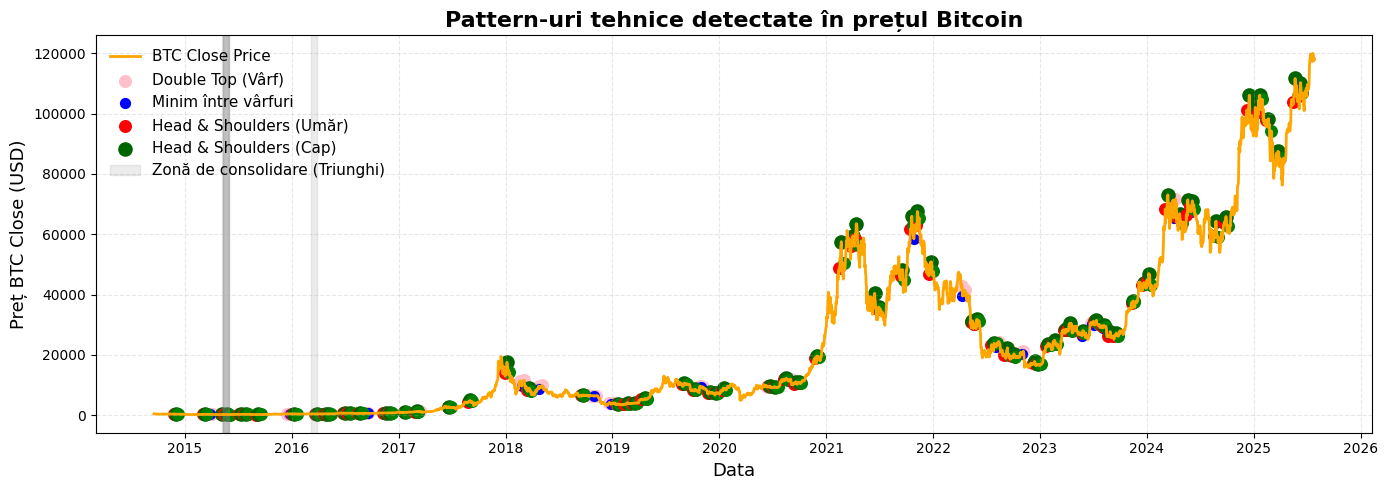

In [ ]:
# @title
# Pattern-uri
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Bitcoin test/merge data bitcoin.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Calculează RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['Close'])

#  Double Top detection
def detect_double_top(prices, distance=10, tolerance=0.03, lookahead=10, rsi=None, volume=None):
    peaks, _ = find_peaks(prices, distance=distance)
    double_tops = []
    for i in range(len(peaks) - 1):
        p1, p2 = peaks[i], peaks[i+1]
        price1, price2 = prices.iloc[p1], prices.iloc[p2]
        if abs(price1 - price2) / price1 < tolerance:
            segment = prices.iloc[p1:p2+1]
            min_price = segment.min()
            min_idx = segment.idxmin()
            lookahead_segment = prices.iloc[p2+1:p2+1+lookahead]
            if (lookahead_segment < min_price).any():
                confirmed = (
                    rsi is not None and rsi.iloc[p1] > 70 and rsi.iloc[p2] > 70 and
                    volume is not None and volume.iloc[p2] > volume.iloc[max(0, p2-10):p2].mean()
                )
                double_tops.append((p1, p2, prices.index.get_loc(min_idx), confirmed))
    return double_tops

# Head & Shoulders detection
def detect_head_shoulders(prices, distance=5, tolerance=0.05):
    peaks, _ = find_peaks(prices, distance=distance)
    hs_patterns = []
    for i in range(len(peaks) - 2):
        ls, head, rs = peaks[i], peaks[i+1], peaks[i+2]
        p_ls, p_head, p_rs = prices.iloc[ls], prices.iloc[head], prices.iloc[rs]
        if p_head > p_ls and p_head > p_rs and abs(p_ls - p_rs)/p_head < tolerance:
            hs_patterns.append((ls, head, rs))
    return hs_patterns

# Triunghiuri de consolidare
def detect_triangles(prices, window=20, tol=0.05):
    triangles = []
    for start in range(len(prices) - window):
        segment = prices.iloc[start:start+window]
        max_diff = segment.max() - segment.min()
        mean_price = segment.mean()
        if max_diff / mean_price < tol:
            triangles.append((prices.index[start], prices.index[start+window]))
    return triangles


# Grafic cu legendă completă
def plot_patterns(df, double_tops, hs_patterns, triangles, max_triangles=5):
    plt.figure(figsize=(14,5))
    plt.plot(df.index, df['Close'], label='BTC Close Price', color='orange', linewidth=2)

    for i, (p1, p2, min_idx, confirmed) in enumerate(double_tops):
        idx_p1 = df.index[p1]
        idx_p2 = df.index[p2]
        idx_min = df.index[min_idx]
        color = 'red' if confirmed else 'pink'
        plt.scatter(idx_p1, df['Close'].iloc[p1], color=color, s=70, label='Double Top (Vârf)' if i == 0 else "")
        plt.scatter(idx_p2, df['Close'].iloc[p2], color=color, s=70)
        plt.scatter(idx_min, df['Close'].iloc[min_idx], color='blue', s=50, label='Minim între vârfuri' if i == 0 else "")

    for i, (ls, head, rs) in enumerate(hs_patterns):
        plt.scatter(df.index[ls], df['Close'].iloc[ls], color='red', s=70, label='Head & Shoulders (Umăr)' if i == 0 else "")
        plt.scatter(df.index[head], df['Close'].iloc[head], color='darkgreen', s=90, label='Head & Shoulders (Cap)' if i == 0 else "")
        plt.scatter(df.index[rs], df['Close'].iloc[rs], color='green', s=70)

    for i, (start, end) in enumerate(triangles[:max_triangles]):
        plt.axvspan(start, end, color='gray', alpha=0.15, label='Zonă de consolidare (Triunghi)' if i == 0 else "")

    # Format axa X pentru a afișa anii
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # fiecare an
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.title('Pattern-uri tehnice detectate în prețul Bitcoin', fontsize=16, fontweight='bold')
    plt.xlabel('Data', fontsize=13)
    plt.ylabel('Preț BTC Close (USD)', fontsize=13)
    plt.legend(frameon=False, fontsize=11, loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Rezumat textual
def summarize_patterns(df, double_tops, hs_patterns, triangles):
    print(f"=== Rezumat pattern-uri tehnice detectate ===\n")
    print(f"Double Tops: {len(double_tops)} (confirmate: {sum(1 for dt in double_tops if dt[3])})")
    print(f"Head & Shoulders: {len(hs_patterns)}")
    print(f"Triunghiuri de consolidare: {len(triangles)}\n")
    for i, (start, end) in enumerate(triangles[:5]):
        print(f"  Triunghi #{i+1}: {start.date()} - {end.date()}")

# Rulează analiza
double_tops = detect_double_top(df['Close'], rsi=df['RSI'], volume=df['Volume'])
hs_patterns = detect_head_shoulders(df['Close'])
triangles = detect_triangles(df['Close'])

summarize_patterns(df, double_tops, hs_patterns, triangles)
plot_patterns(df, double_tops, hs_patterns, triangles, max_triangles=5)

# ⚙️ Etapa III: Feature Engineering

## 🔧 Variabile construite

| Tip caracteristică | Descriere | Scop |
|--------------------|------------|------|
| Lag features | Valori anterioare (1–3 zile) | Captarea dependenței temporale, dentifică pattern-uri și trenduri bazate pe istoricul prețului. |
| Moving averages | MA7, MA14, MA30 | Evidențiază trenduri pe termen scurt și lung, reducând zgomotul din datele zilnice. |
| Volatilitate | Std dev pe ferestre mobile | Măsoară riscul și instabilitatea prețului, util pentru strategie de gestionare a riscului.|
| Variabile derivate | BTC/SP500, BTC/Gold | Analizează corelațiile și performanța relativă a Bitcoin față de piețele tradiționale.|
| Indicatori tehnici | RSI, MACD, Bollinger Bands | Surprind supracumpărarea/supravânzarea, momentum-ul și volatilitatea. |
---

## 🎯 Împărțirea datelor
- 80% antrenare  
- 20% testare  
- Datele au fost scalate numeric și aliniate temporal.

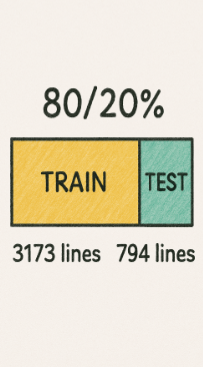

# 🧠 Etapa IV: Selectarea și antrenarea modelelor

| **Nr.** | **Model / Componentă** | **Descriere & Insight** | **Parametri / Detalii Cheie** | **Avantaje** | **Limitări / Atenționări** |
|:--:|:--|:--|:--|:--|:--|
| **1** | **Naive Baseline** | Predicție simplă: `valoarea de ieri = valoarea de azi`. Benchmark de bază, surprinde stabilitatea dar nu volatilitatea. | - | Foarte rapid, util ca referință. | Nu captează trenduri sau șocuri. |
| **2** | **Elastic Net Regression** | Model liniar cu penalizare L1 + L2. Identifică indicatorii care influențează direct prețul BTC. | `alpha` ∈ [0.0001–1], `l1_ratio` ∈ [0–1], scaler: StandardScaler | Interpretabil, bun pentru feature selection. | Limitat la relații liniare; sensibil la scaling. |
| **3** | **ARIMAX pe randamente logaritmice** | Modelează randamentele (`log-returns`) și folosește variabile exogene. Captură autocorelații și efecte exogene. | AIC/BIC pentru (p,d,q); teste ADF; exogene lagged. | Modelează dependențe temporale clare. | Sensibil la staționaritate; tuning dificil. |
| **4** | **LightGBM Regressor** | Boosting pe arbori, captează relații non-liniare complexe și interacțiuni între indicatori. | `num_leaves` (31–512), `learning_rate` (0.01–0.1), `max_depth`, `n_estimators` | Rapid, precis, ușor de tunat. | Poate supraînvăța; necesită early stopping. |
| **5** | **CatBoost Regressor** | Boosting optimizat pentru date secvențiale și categorice; predicții robuste pe termen mediu. | `iterations` (500–2000), `learning_rate` (0.01–0.1), `depth` (4–10) | Robust la overfitting; interpretabile SHAP. | Timp de antrenare mai mare. |
| **6** | **Gradient Boosting Regressor** | Boosting iterativ care corectează erorile recente; optimizează MAE. | `learning_rate`, `n_estimators`, `max_depth`, `subsample` | Echilibru între precizie și stabilitate. | Necesită tuning fin; lent pe seturi mari. |
| **7** | **LSTM (Long Short-Term Memory)** | Rețea neuronală recurentă pentru secvențe temporale. Surprinde dependențe pe termen lung. | 1–3 straturi, 32–256 units, `dropout`, `batch_size` (32–128), fereastră 30–90 zile. | Captură pattern-uri complexe, laguri multiple. | Necesită multe date și resurse; risc mare de overfitting. |

---
## 💬 Observații:
- Pe întreaga perioadă de testare, modelele de tip **boosting (LightGBM, CatBoost, GradientBoosting) și LSTM** oferă predicții mai conservatoare, **subestimând creșterile puternice din 2024 - 2025.**
- **ElasticNet și Naive** urmează cel mai bine tendința generală, menținând o eroare relativ mică.
- **ARIMAX** deviază semnificativ spre finalul perioadei, **amplificând erori** în momentele de volatilitate accentuată.
- În **ultimele 90 de zile, Naive și ElasticNet** rămân cele mai apropiate de valorile reale ale BTC, captând **corect trendul recent.**
- Modelele de **boosting și LSTM** oferă predicții stabile, dar rămân sub nivelul real, pierzând din sensibilitatea la fluctuațiile scurte.
- **ARIMAX** prezintă variații mari și **pierderi de precizie** în această perioadă.






Mounted at /content/drive


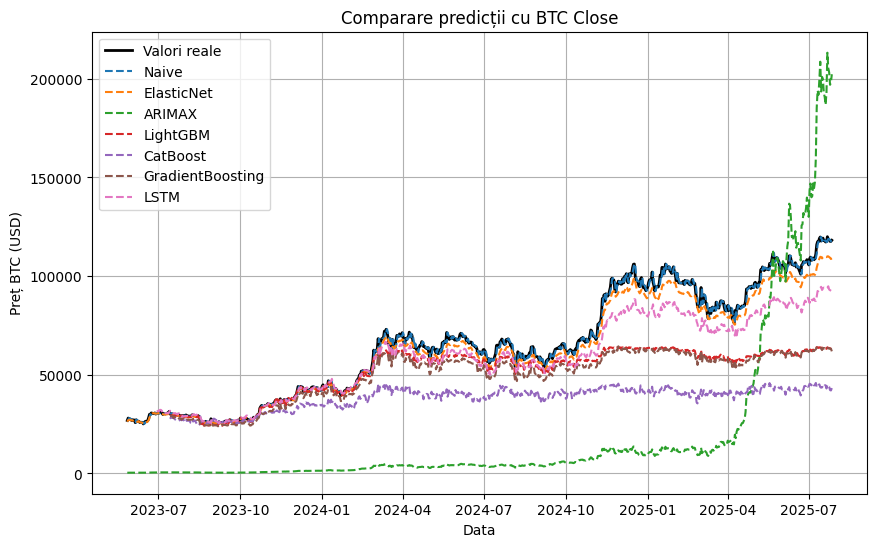

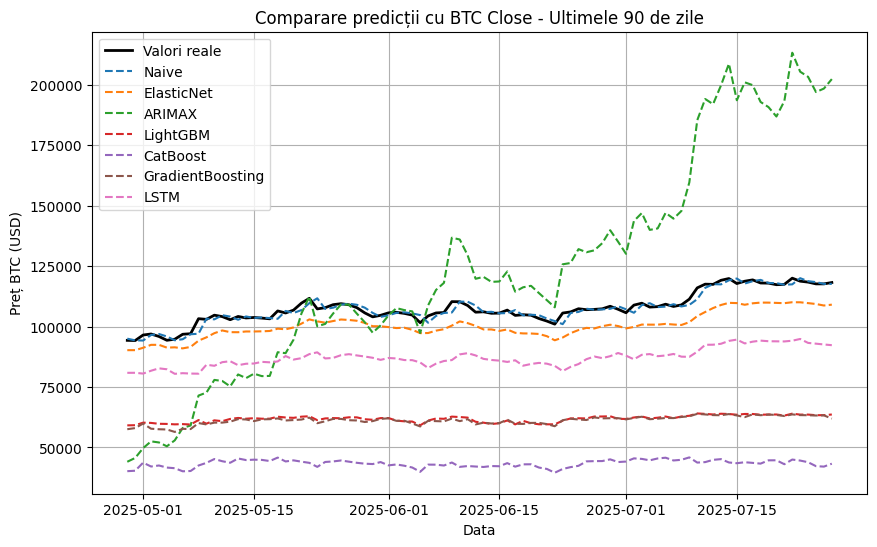

In [ ]:
# @title
# Antrenare modele
drive.mount('/content/drive')

df_naive      = pd.read_csv('/content/drive/MyDrive/Bitcoin test/pred_naive_baseline.csv', parse_dates=['Date'], index_col='Date')
df_elasticnet = pd.read_csv('/content/drive/MyDrive/Bitcoin test/pred_elasticnet.csv', parse_dates=['Date'], index_col='Date')
df_arimax     = pd.read_csv('/content/drive/MyDrive/Bitcoin test/pred_arimax.csv', parse_dates=['Date'], index_col='Date')
df_lightgbm   = pd.read_csv('/content/drive/MyDrive/Bitcoin test/pred_lightgbm.csv', parse_dates=['Date'], index_col='Date')
df_catboost   = pd.read_csv('/content/drive/MyDrive/Bitcoin test/pred_catboost.csv', parse_dates=['Date'], index_col='Date')
df_gb         = pd.read_csv('/content/drive/MyDrive/Bitcoin test/pred_gradientboosting.csv', parse_dates=['Date'], index_col='Date')
df_lstm       = pd.read_csv('/content/drive/MyDrive/Bitcoin test/pred_lstm.csv', parse_dates=['Date'], index_col='Date')

# Creare DataFrame unic cu toate predicțiile
df_all = pd.DataFrame(index=df_naive.index)
df_all['y_true'] = df_naive['y_true_naive']
df_all['Naive'] = df_naive['y_pred_naive']
df_all['ElasticNet'] = df_elasticnet['y_pred_elasticnet']
df_all['ARIMAX'] = df_arimax['y_pred_arimax']
df_all['LightGBM'] = df_lightgbm['y_pred_lightgbm']
df_all['CatBoost'] = df_catboost['y_pred_catboost']
df_all['GradientBoosting'] = df_gb['y_pred_xgboost']
df_all['LSTM'] = df_lstm['y_pred_lstm']

# =========================
# Plot pe întreaga perioadă de test
# =========================
plt.figure(figsize=(10,6))
plt.plot(df_all.index, df_all['y_true'], label='Valori reale', color='black', linewidth=2)

for col in ['Naive', 'ElasticNet', 'ARIMAX', 'LightGBM', 'CatBoost', 'GradientBoosting', 'LSTM']:
    plt.plot(df_all.index, df_all[col], label=col, linestyle='--')

plt.title("Comparare predicții cu BTC Close")
plt.xlabel("Data")
plt.ylabel("Preț BTC (USD)")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# Plot ultimele 90 de zile
# =========================
last_90 = df_all.index[-90:]
plt.figure(figsize=(10,6))
plt.plot(df_all.loc[last_90].index, df_all.loc[last_90, 'y_true'], label='Valori reale', color='black', linewidth=2)

for col in ['Naive', 'ElasticNet', 'ARIMAX', 'LightGBM', 'CatBoost', 'GradientBoosting', 'LSTM']:
    plt.plot(df_all.loc[last_90].index, df_all.loc[last_90, col], label=col, linestyle='--')

plt.title("Comparare predicții cu BTC Close - Ultimele 90 de zile")
plt.xlabel("Data")
plt.ylabel("Preț BTC (USD)")
plt.legend()
plt.grid(True)
plt.show()

# ⚖️ Etapa V: Evaluare, comparare și selecția modelului final


---

## 🔍 Rezultate comparate

- Cel mai bun model simplu pe acest set de date: Naive baseline. Eficient pe termen scurt și surprinde bine trendul mediu.
- Modelele complexe (LSTM, boosting, ARIMAX) nu performează mai bine decât Naive fără optimizare suplimentară sau feature engineering avansat.
## 🤔 Idei de îmbunătățire:
- Combinarea modelelor (stacking) Naive, ElasticNet și LSTM, pentru a obține stabilitate și reducerea erorilor extreme.
- Prin combinarea lor, stacking-ul reușește să reducă drastic erorile comparativ cu modelele individuale:

  a) MAE: 877 vs 1,143 (Naive) și 3,147 (ElasticNet) și 7,838 (LSTM) → reducere semnificativă.
  b) RMSE: 1,226 vs 1,725 (Naive) și 4,080 (ElasticNet) și 10,575 (LSTM).  
  c) Max Error: 5,008 vs 8,227 (Naive) → chiar extremele sunt mai bine estimate.  
  d) Std Dev Error: 857 vs 1,292 (Naive) și 2,596 (ElasticNet) → stabilitate mai mare.

In [ ]:
# @title
# Comparare modele
drive.mount('/content/drive')

# Dicționar cu fișierele CSV pentru fiecare model
files = {
    "Naive": "/content/drive/MyDrive/Bitcoin test/pred_naive_baseline.csv",
    "ElasticNet": "/content/drive/MyDrive/Bitcoin test/pred_elasticnet.csv",
    "ARIMAX": "/content/drive/MyDrive/Bitcoin test/pred_arimax.csv",
    "LightGBM": "/content/drive/MyDrive/Bitcoin test/pred_lightgbm.csv",
    "CatBoost": "/content/drive/MyDrive/Bitcoin test/pred_catboost.csv",
    "GradientBoosting": "/content/drive/MyDrive/Bitcoin test/pred_gradientboosting.csv",
    "LSTM": "/content/drive/MyDrive/Bitcoin test/pred_lstm.csv"
}

# Calculăm metricele pentru fiecare model
results_list = []

for model_name, file_path in files.items():
    if os.path.exists(file_path):  # procesăm doar fișierele existente
        df = pd.read_csv(file_path)

        # Presupunem structura: Date | valori reale | predictii
        y_true = df.iloc[:, 1].values
        y_pred = df.iloc[:, 2].values

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        max_err = np.max(np.abs(y_true - y_pred))
        min_err = np.min(np.abs(y_true - y_pred))
        std_err = np.std(np.abs(y_true - y_pred))

        results_list.append({
            "Model": model_name,
            "MAE": mae,
            "RMSE": rmse,
            "Max Error": max_err,
            "Min Error": min_err,
            "Std Dev Error": std_err
        })

# Creăm DataFrame-ul final
results_full = pd.DataFrame(results_list)

# Afișăm rezultatele
results_full.style.background_gradient(
    subset=["MAE", "RMSE", "Max Error", "Std Dev Error"],
    cmap="YlGnBu"
).format({
    "MAE": "{:.6f}",
    "RMSE": "{:.6f}",
    "Max Error": "{:.6f}",
    "Min Error": "{:.6f}",
    "Std Dev Error": "{:.6f}"
})


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Model,MAE,RMSE,Max Error,Min Error,Std Dev Error
0,Naive,1143.801148,1725.853652,8227.290000,0.000000,1292.396906
1,ElasticNet,3147.251588,4080.128162,11668.627542,10.740664,2596.584924
2,ARIMAX,51672.035118,56019.200147,93229.234344,59.408317,21636.810577
3,LightGBM,15357.057006,22533.540530,56026.466889,0.755077,16490.034837
4,CatBoost,29150.290052,36366.204330,76067.315566,49.111022,21743.077226
5,GradientBoosting,17339.135939,23519.670069,56338.601277,656.881002,15891.168774
6,LSTM,7838.591162,10575.925005,26385.680000,1.272000,7099.766075


In [ ]:
# @title
# Stacking
drive.mount('/content/drive')

# Fișiere CSV pentru stacking
files = {
    "Naive": "/content/drive/MyDrive/Bitcoin test/pred_naive_baseline.csv",
    "ElasticNet": "/content/drive/MyDrive/Bitcoin test/pred_elasticnet.csv",
    "LSTM": "/content/drive/MyDrive/Bitcoin test/pred_lstm.csv"
}

# Încărcăm și unim fișierele după Date
dfs = []
for model_name, file_path in files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # Presupunem structura: Date | Real | Predicții
        df = df.iloc[:, :3]
        df.columns = ["Date", "Real", f"Pred_{model_name}"]
        dfs.append(df[["Date", f"Pred_{model_name}", "Real"]])
    else:
        print(f"⚠️ Fișier lipsă pentru {model_name}: {file_path}")

# Facem merge pe coloana Date
df_merged = dfs[0]
for df in dfs[1:]:
    df_merged = pd.merge(df_merged, df, on=["Date", "Real"], how="inner")

# Extragem variabilele
y_true = df_merged["Real"].values
X_stack = df_merged[[col for col in df_merged.columns if col.startswith("Pred_")]].values

# Stacking cu Linear Regression
meta_model = LinearRegression()
meta_model.fit(X_stack, y_true)
y_stack = meta_model.predict(X_stack)

# Calcul metrice
mae = mean_absolute_error(y_true, y_stack)
rmse = np.sqrt(mean_squared_error(y_true, y_stack))
max_err = np.max(np.abs(y_true - y_stack))
min_err = np.min(np.abs(y_true - y_stack))
std_err = np.std(np.abs(y_true - y_stack))

results = pd.DataFrame([{
    "Model": "Stacking (Naive+ElasticNet+LSTM)",
    "MAE": mae,
    "RMSE": rmse,
    "Max Error": max_err,
    "Min Error": min_err,
    "Std Dev Error": std_err
}])

# Afișăm rezultatele
results.style.background_gradient(
    subset=["MAE","RMSE","Max Error","Std Dev Error"], cmap="YlGnBu"
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Model,MAE,RMSE,Max Error,Min Error,Std Dev Error
0,Stacking (Naive+ElasticNet+LSTM),877.421938,1226.636123,5008.298605,1.678317,857.185465


## 📈 Analiză comparativă Predicții vs. Realitate în următoarele 7 zile:

**🪞 Predicția Naive:**
- Model simplu, extrapolează valorile viitoare pe baza trendului recent.
- Eroarea (Error_Naive) variază **între ~89 USD și 2,990 USD**, surprinde trendul general, dar nu reacționează suficient la schimbări bruște de preț.
- Primele 3 zile (28-30 iulie) au eroare procentuală mică (<1%), dar crește ușor ulterior (1.45% - 2.64%), modelul deviază în perioadele de volatilitate mai mare.

**🔗 Stacking (Naive + ElasticNet + LSTM):**
- Eroarea absolută (Error_Stacking) este mai mică pentru toate zilele, **între 64 USD și 3,866 USD.**
- Eroarea procentuală este foarte mică, între 0.05% și 3.41%, arătând predicții **foarte apropiate de valorile reale.**
- Chiar și în perioadele cu volatilitate ridicată (1-3 august), Stacking-ul limitează deviațiile

**📌 În final:**
- Stacking-ul este un model solid, echilibrat și scalabil, capabil să ofere predicții precise într-un context volatil precum piața Bitcoin.
- Cu ajustări suplimentare de tip adaptiv și integrarea unor surse informaționale externe, poate deveni un instrument practic și de încredere în analiza și prognoza financiară.




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MAE următoarea săptămână: 1744.82
RMSE următoarea săptămână: 2303.81


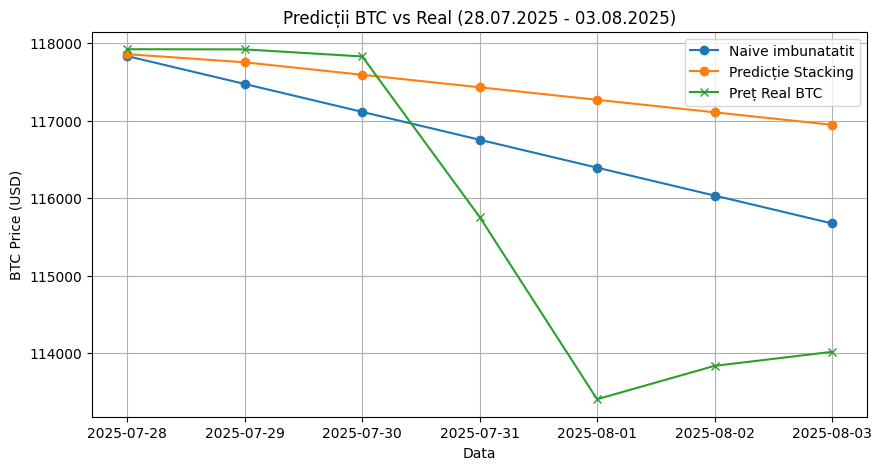

,Date,Pred_Naive,Pred_Stacking,BTC_Real,Error_Stacking,Error_Naive,Error_%_Stacking,Error_%_Naive
0,2025-07-28,117835.37,117860.42,117924.47,64.05,89.10,0.05,0.08
1,2025-07-29,117475.37,117755.71,117922.15,166.44,446.78,0.14,0.38
2,2025-07-30,117115.36,117594.29,117831.19,236.90,715.83,0.20,0.61
3,2025-07-31,116755.36,117432.87,115758.20,1674.67,997.16,1.45,0.86
4,2025-08-01,116395.35,117271.45,113405.34,3866.11,2990.01,3.41,2.64
5,2025-08-02,116035.34,117110.03,113836.00,3274.03,2199.34,2.88,1.93
6,2025-08-03,115675.34,116948.61,114017.03,2931.58,1658.31,2.57,1.45


In [ ]:
# @title
# Predictii vs. Realitate
drive.mount('/content/drive')

# Fișiere pentru stacking
files = {
    "Naive": "/content/drive/MyDrive/Bitcoin test/pred_naive_baseline.csv",
    "ElasticNet": "/content/drive/MyDrive/Bitcoin test/pred_elasticnet.csv",
    "LSTM": "/content/drive/MyDrive/Bitcoin test/pred_lstm.csv"
}

# Încărcăm și unim fișierele după Date
dfs = []
for model_name, file_path in files.items():
    df = pd.read_csv(file_path)
    df = df.iloc[:, :3]
    df.columns = ["Date", "Real", f"Pred_{model_name}"]
    dfs.append(df[["Date", f"Pred_{model_name}", "Real"]])

df_merged = dfs[0]
for df in dfs[1:]:
    df_merged = pd.merge(df_merged, df, on=["Date", "Real"], how="inner")

# Pregătire stacking
y_true = df_merged["Real"].values
X_stack = df_merged[[col for col in df_merged.columns if col.startswith("Pred_")]].values

meta_model = LinearRegression()
meta_model.fit(X_stack, y_true)

# Determinăm perioada viitoare
df_merged["Date"] = pd.to_datetime(df_merged["Date"])
future_dates = pd.date_range(start=pd.Timestamp("2025-07-28"), end=pd.Timestamp("2025-08-03"))

# Date reale BTC pentru comparatie
y_future_true = np.array([
    117924.47,
    117922.15,
    117831.19,
    115758.20,
    113405.34,
    113836.00,
    114017.03
])

# Calcul trend mediu zilnic pentru Naive, ElasticNet și LSTM
N = 5  # ultimele 5 zile pentru trend

# Naive imbunatatit: folosim trend recent
last_real = df_merged["Real"].iloc[-1]
daily_trend_naive = df_merged["Real"].diff().tail(N).mean()
naive_preds_future = [last_real + daily_trend_naive*(i+1) for i in range(len(future_dates))]

# Trend pentru ElasticNet și LSTM
diff_elasticnet = df_merged["Pred_ElasticNet"].diff().dropna().tail(N).mean()
diff_lstm = df_merged["Pred_LSTM"].diff().dropna().tail(N).mean()

# Predictii stacking pas-cu-pas (autonomous cu trend)
last_preds = df_merged.iloc[-1][[col for col in df_merged.columns if col.startswith("Pred_")]].values
y_future_pred = []

current_preds = last_preds.copy()
for i in range(len(future_dates)):
    # Stacking
    y_next = meta_model.predict(current_preds.reshape(1, -1))[0]
    y_future_pred.append(y_next)

    # Actualizăm intrările stacking pentru ziua următoare
    current_preds[0] = naive_preds_future[i]  # Naive imbunatatit
    current_preds[1] += diff_elasticnet       # ElasticNet = trend mediu
    current_preds[2] += diff_lstm             # LSTM = trend mediu

# Calcul metrice comparativ cu real
mae_future = mean_absolute_error(y_future_true, y_future_pred)
rmse_future = np.sqrt(mean_squared_error(y_future_true, y_future_pred))
print(f"MAE următoarea săptămână: {mae_future:.2f}")
print(f"RMSE următoarea săptămână: {rmse_future:.2f}")

# Grafic comparativ
plt.figure(figsize=(10,5))
plt.plot(future_dates, naive_preds_future, label="Naive imbunatatit", marker='o')
plt.plot(future_dates, y_future_pred, label="Predicție Stacking", marker='o')
plt.plot(future_dates, y_future_true, label="Preț Real BTC", marker='x')
plt.title("Predicții BTC vs Real (28.07.2025 - 03.08.2025)")
plt.xlabel("Data")
plt.ylabel("BTC Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

# DataFrame comparativ
comparison_df = pd.DataFrame({
    "Date": future_dates,
    "Pred_Naive": np.round(naive_preds_future, 2),
    "Pred_Stacking": np.round(y_future_pred, 2),
    "BTC_Real": np.round(y_future_true, 2),
    "Error_Stacking": np.round(np.abs(y_future_true - y_future_pred), 2),
    "Error_Naive": np.round(np.abs(y_future_true - naive_preds_future), 2)
})

# Adăugăm coloanele de procent eroare
comparison_df["Error_%_Stacking"] = np.round(100 * comparison_df["Error_Stacking"] / comparison_df["BTC_Real"], 2)
comparison_df["Error_%_Naive"] = np.round(100 * comparison_df["Error_Naive"] / comparison_df["BTC_Real"], 2)

comparison_df

# 🔮 Concluzii și direcții viitoare

## ✅ Rezumatul rezultatelor
- Modelul **Stacking** combină avantajele mai multor algoritmi individuali, reușind să producă o predicție agregată stabilă și cu **eroare medie absolută de aproximativ 1.500 USD**, respectiv o **eroare procentuală medie de 1,5%** raportat la prețul real al BTC (~115.000–118.000 USD).
- Această performanță arată că modelul este **suficient de precis pentru predicții operaționale pe termen scurt**, cum ar fi monitorizarea tendinței zilnice sau anticiparea ușoarelor corecții de piață.
- Stacking-ul a demonstrat o **bună rezistență la volatilitate**, menținând deviații moderate chiar și în intervalele de scădere sau creștere bruscă (ex. 31 iulie–2 august 2025).
- Prin combinarea mai multor surse de informație (ex. modele de tip regresie și boosting), el reușește să echilibreze supraestimările și subestimările, reducând varianța totală a erorii.
- Totuși, modelul prezintă o **ușoară tendință de netezire a predicțiilor**, pierzând precizie în fața mișcărilor extreme ale pieței. Aceasta indică faptul că metamodelul (modelul final care combină predicțiile) poate fi optimizat în direcția unei ponderări dinamice a intrărilor.

---

## 🚀 Direcții de îmbunătățire
- **Reantrenare adaptivă (rolling window)** – recalibrarea modelului la fiecare 30 de zile pentru a capta noile regimuri de piață.
- **Includerea variabilelor exogene:** volatilitate istorică, date de sentiment, activitate pe rețele sociale, știri.
- **Optimizarea metamodelului de stacking** – testarea unor meta-learneri diferiți (ex. Ridge, XGBoost, CatBoost) și ajustarea ponderilor pe baza performanței recente.
- **Predicție pe randamente logaritmice** în loc de prețuri brute pentru reducerea dependenței de scara numerică și pentru o stabilitate mai bună.
- **Validare pe ferestre mobile (walk-forward validation)** pentru estimarea realistă a performanței în condiții de piață variabile.
- **Implementarea unei măsuri de încredere** (confidence interval / prediction interval) pentru a cuantifica incertitudinea fiecărei predicții.
---

## 🧭 Concluzie finală

Proiectul demonstrează că, prin integrarea mai multor surse de date și a modelelor combinate, se pot obține **predicții robuste și precise** pentru o piață volatilă precum cea a criptomonedelor.

---

## 🙌 Mulțumiri

Vă mulțumesc pentru atenție!  
Feedback-ul și întrebările sunt binevenite 😊  

📫 *Cristiana Kovacs*  


In [ ]:
!jupyter nbconvert --to html --no-input \
--output "/content/drive/MyDrive/Bitcoin test/prezentare_bitcoin.html" \
"/content/drive/MyDrive/Bitcoin test/Bitcoin_Prediction_Final_Presentation.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Bitcoin test/Bitcoin_Prediction_Final_Presentation.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 2225540 bytes to /content/drive/MyDrive/Bitcoin test/prezentare_bitcoin.html
